# Driveable Area Segmenation with YOLO
This notebook **previously** was named "Driveable Area Segmenation with YOLO". This worked fine so far, but as shown in the notebook "Lanedetection from Driveable Area Segmentation", getting lanes from the driveable area seems challanging when the images are under bad lighting codition. This is especially challanging when shadows are involved, because they change the overall color of a lane drastically. Furthermore, there are to main types of lanes, passable and inpassable, so lanes with and without gabs. This makes it hard to get the lanes right when using only image processing. Some examples worked great but other need a lot of tweeking, than worked and the next image needed more tweeking an so on. So the AI should also **segment the lanes** too.

The training later was done again the the **overlap_mask** set to **false**. In the previous version it was set to true. Like also descriped in the "Lanedetection from Driveable Area Segmentation" Notebook, this smashed the mask together, creating holes in the driveable area segments where the lanes (the smaller segments) are. Therefore only one class was learned per pixel during training. This is not a problem, but the dataset was not made for this variant and so was inefficent for a good prediction.

## Setup

In [1]:
%%capture
! wget "https://arcxyon.com/wp-content/uploads/2025/08/ets2_data_segmentation_07-08-2025.zip"
! unzip "ets2_data_segmentation_07-08-2025.zip"

In [2]:
train_img_path = "ets2_data_segmentation_07-08-2025/images/train/"

In [3]:
from PIL import Image
import os
import random
import cv2

def get_random_cv2_img(path, only_path=False):
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    random_sample = random.choice(files)
    if only_path:
        return random_sample
    else:
        return cv2.imread(os.path.join(path, random_sample))

In [4]:
import matplotlib.pyplot as plt

def show(img, cv2_img = False):
    if cv2_img: 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 10)) # img display size
    plt.imshow(img)
    plt.axis('off')
    plt.show()

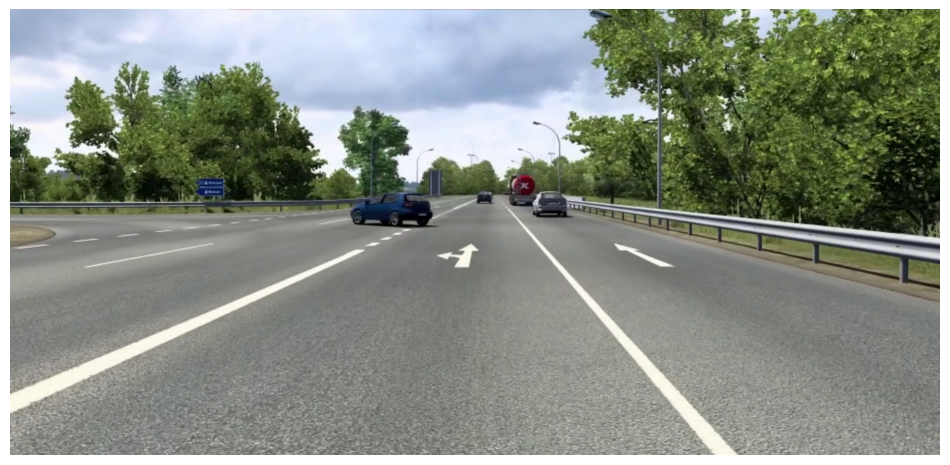

In [5]:
show(get_random_cv2_img(train_img_path), cv2_img=True)

In [6]:
get_random_cv2_img(train_img_path).shape

(920, 1920, 3)

## Define some image preprocessing

Adaptive Gamma:
- Very dark pixels (near 0) → apply strong gamma (e.g., ~1.5)
- Mid-range pixels → apply mild gamma (~1.2)
- Bright pixels → apply little to no gamma (~1.0)

Conditional CLAHE:
- Only apply for dark images.

In [7]:
import numpy as np

def process_image(img): 
    # Step 1: Conditional CLAHE
    # extract luminance channel
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    luminance = img_yuv[:, :, 0]
    avg_brightness = np.mean(luminance)

    if avg_brightness < 50:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_clahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    else:
        img_clahe = img.copy()

    # Step 2: Gamma Correction
    lut = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        # normalize pixel value to [0, 1]
        normalized = i / 255.0
        # adaptive gamma factor (current maximum: 1.5)
        gamma = 1.0 + (1.5 - 1.0) * (1 - normalized)  # gamma decreases with brightness
        corrected = pow(normalized, 1.0 / gamma)
        lut[i] = np.clip(corrected * 255, 0, 255)
    img_bright = cv2.LUT(img, lut)


    # Step 3: Unsharp Masking
    blurred = cv2.GaussianBlur(img_bright, (0, 0), sigmaX=2)
    amount = 1.5
    return cv2.addWeighted(img_bright, 1 + amount, blurred, -amount, 0)

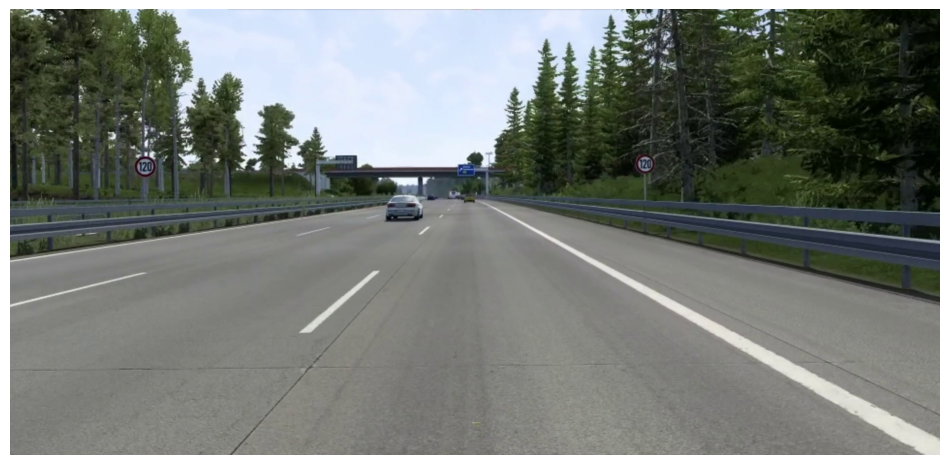

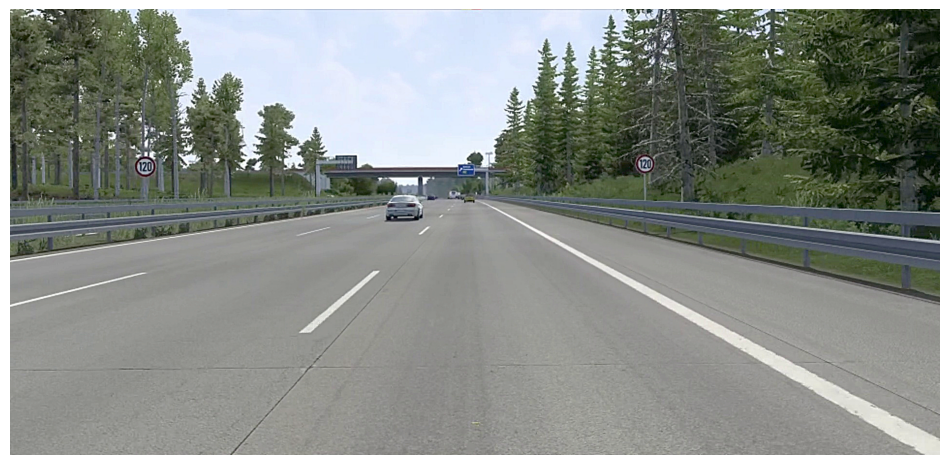

In [8]:
img = get_random_cv2_img(train_img_path)
show(img, cv2_img=True)
show(process_image(img), cv2_img=True)

## Process all files

In [9]:
from tqdm.notebook import tqdm

train_img_path = "ets2_data_segmentation_07-08-2025/images/train/"

files = [f for f in os.listdir(train_img_path) if os.path.isfile(os.path.join(train_img_path, f))]

for file in tqdm(files, desc="Processing images"):
    filename = os.path.basename(file)
    path = os.path.join(train_img_path, filename)
    cv2.imwrite(path, process_image(cv2.imread(path)))

Processing images:   0%|          | 0/155 [00:00<?, ?it/s]

In [10]:
val_img_path = "ets2_data_segmentation_07-08-2025/images/val/"

files = [f for f in os.listdir(val_img_path) if os.path.isfile(os.path.join(val_img_path, f))]

for file in tqdm(files, desc="Processing images"):
    filename = os.path.basename(file)
    path = os.path.join(val_img_path, filename)
    cv2.imwrite(path, process_image(cv2.imread(path)))

Processing images:   0%|          | 0/17 [00:00<?, ?it/s]

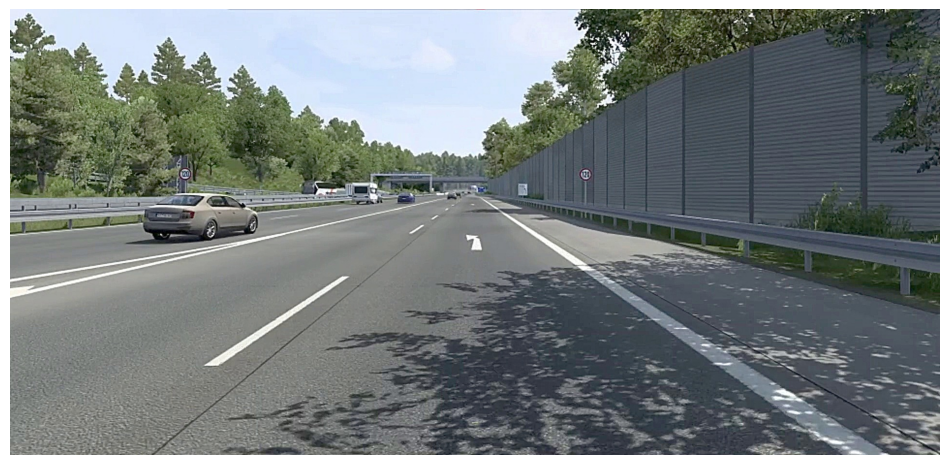

In [11]:
show(get_random_cv2_img(train_img_path), True)

## Training

In [12]:
%%capture
! pip install ultralytics

In [13]:
data = "ets2_data_segmentation_07-08-2025/data.yaml"
! cat "ets2_data_segmentation_07-08-2025/data.yaml"

path: ets2_data_segmentation_07-08-2025/ # dataset root dir
train: images/train # train images (relative to 'path') 4 images
val: images/val # val images (relative to 'path') 4 images

# Classes
names:
  0: Driveable   # 3: Driveable
  1: Passable    # 4: Passable
  2: Impassable  # 5: Impassable


In [14]:
import torch

# Clear cache
torch.cuda.empty_cache()

# Optional: Collect unused memory from Python garbage collector
import gc
gc.collect()

# If using newer PyTorch and CUDA version:
torch.cuda.ipc_collect()

Use 920 x 1920 each devided by 2, so the images are not rescaled unnaturaly, details are still present but fit on the avavible gpu specially with a medium batch size.

Note: Set the overlap_mask parameter to false.

In [ ]:
from ultralytics import YOLO
model = YOLO("yolo11m-seg.pt")

results = model.train(data=data, batch=8, epochs=300, imgsz=(920//2, 1920//2), device=[0, 1], overlap_mask=False)

## Test

In [18]:
%%capture
! wget "https://arcxyon.com/wp-content/uploads/2025/08/Raw_Examples_04-08-2025.zip"
! unzip "Raw_Examples_04-08-2025.zip"

In [19]:
example_img_path = "67/"

Note: Make sure to process the input images according to the preprocessing step of the training images and also convert from BGR to RGB before feeding into the network.

In [20]:
def get_lane_segmentation(img):

    working_img = img.copy()
    working_img = process_image(working_img)
    working_img = cv2.cvtColor(working_img, cv2.COLOR_BGR2RGB)
    
    # use model.predict on specific device
    results = model.predict(working_img, device='cuda:0', batch=1)

    overlay = img.copy()

    # Define class-to-color mapping (BGR)
    class_colors = {
        0: (0, 255, 255),  # driveable - Yellow
        1: (0, 255, 0),    # passable  - Green
        2: (0, 0, 255),    # impassable - Red
    }

    for result in results:
        if result.masks:
            polygons = result.masks.xy
            class_ids = result.boxes.cls.int().tolist()  # Get class IDs as integers

            for polygon, cls_id in zip(polygons, class_ids):
                pts = polygon.astype(int).reshape((-1, 1, 2))
                color = class_colors[cls_id]
                cv2.fillPoly(overlay, [pts], color=color)

    # Blend overlay with original image
    alpha = 0.3
    cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, dst=img)

    return img



0: 480x960 1 Driveable, 1 Passable, 63.8ms
Speed: 5.0ms preprocess, 63.8ms inference, 187.6ms postprocess per image at shape (1, 3, 480, 960)


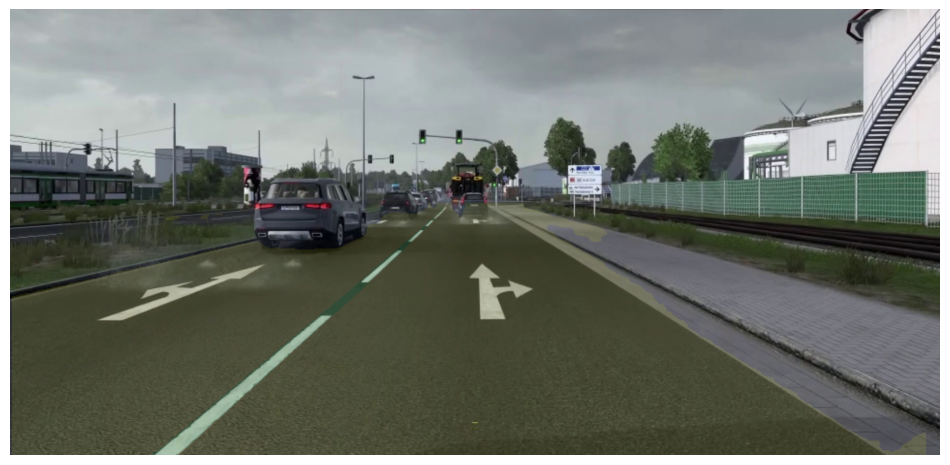

In [21]:
img_name = get_random_cv2_img(example_img_path, True)
img_path = os.path.join(example_img_path, img_name)
img = cv2.imread(img_path)

show(get_lane_segmentation(img), cv2_img=True)


0: 480x960 1 Driveable, 2 Passables, 3 Impassables, 66.3ms
Speed: 3.4ms preprocess, 66.3ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 960)


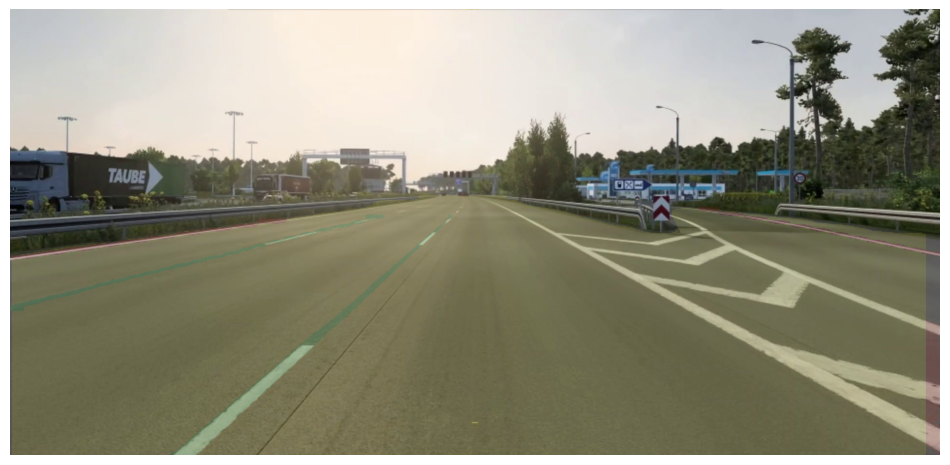

In [22]:
img_name = get_random_cv2_img(example_img_path, True)
img_path = os.path.join(example_img_path, img_name)
img = cv2.imread(img_path)

show(get_lane_segmentation(img), cv2_img=True)

In [ ]:
! wget "https://arcxyon.com/wp-content/uploads/2025/08/ETS2_30-FPS_2025-08-03_14-47-55.mp4"

In [ ]:
from IPython.display import HTML

HTML("""
<video width="640" height="360" controls>
  <source src="ETS2_30-FPS_2025-08-03_14-47-55.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [ ]:
import cv2
from tqdm.notebook import tqdm 

# input and output file paths
input_path = 'ETS2_30-FPS_2025-08-03_14-47-55.mp4' 
output_path = 'ETS2_30-FPS_2025-08-03_14-47-55_processed.mp4'

# open the input video
cap = cv2.VideoCapture(input_path)

# get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Create the video writer
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height - 160), isColor=True)

# process each frame
for _ in tqdm(range(1000), desc="Processing frames"):
    ret, frame = cap.read()
    if not ret:
        break

    frame = frame[160:, :, :]
    
    processed_frame = get_lane_segmentation(process_image(frame))
    out.write(processed_frame)

# release resources
cap.release()
out.release()
cv2.destroyAllWindows()

To display the processed video in the notebook, format it to a codec that is browser compatible.

In [ ]:
! ffmpeg -i "ETS2_30-FPS_2025-08-03_14-47-55_processed.mp4" -vcodec libx264 -acodec aac "ETS2_30-FPS_2025-08-03_14-47-55_processed_browser.mp4"

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="ETS2_30-FPS_2025-08-03_14-47-55_processed_browser.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")